In [699]:
#from google.colab import drive
#drive.mount('/content/drive')

This is the Baseline implementation of a spring mass system since its a baseline model as excepted it fails to match the expectations and hence a HNN was created which performs way better than this barebones model  

In [700]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets 
import torchvision.transforms as transforms 
import torch.utils.data as data_utils 
import numpy as np 
import pytorch_lightning as pl 
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

In [701]:
# creating a dataset

solve_ivp = scipy.integrate.solve_ivp

def hamiltonian_fn(coords):
    q, p = np.split(coords,2)
    H = p**2 + q**2 # spring hamiltonian (linear oscillator)
    return H

def dynamics_fn(t, coords):
    dcoords = autograd.grad(hamiltonian_fn)(coords)
    dqdt, dpdt = np.split(dcoords,2)
    S = np.concatenate([dpdt, -dqdt], axis=-1)
    return S

def get_trajectory(t_span=[0,3], timescale=10, radius=None, y0=None, noise_std=0.1, **kwargs):
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))
    
    # get initial state
    if y0 is None:
        y0 = np.random.rand(2)*2-1
    if radius is None:
        radius = np.random.rand()*0.9 + 0.1 # sample a range of radii
    y0 = y0 / np.sqrt((y0**2).sum()) * radius ## set the appropriate radius

    spring_ivp = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10, **kwargs)
    q, p = spring_ivp['y'][0], spring_ivp['y'][1]
    dydt = [dynamics_fn(None, y) for y in spring_ivp['y'].T]
    dydt = np.stack(dydt).T
    dqdt, dpdt = np.split(dydt,2)
    
    # add noise
    q += np.random.randn(*q.shape)*noise_std
    p += np.random.randn(*p.shape)*noise_std
    return q, p, dqdt, dpdt, t_eval

def get_field(xmin=-1.2, xmax=1.2, ymin=-1.2, ymax=1.2, gridsize=20):
    field = {'meta': locals()}

    # meshgrid to get vector field
    b, a = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(ymin, ymax, gridsize))
    ys = np.stack([b.flatten(), a.flatten()])
    
    # get vector directions
    dydt = [dynamics_fn(None, y) for y in ys.T]
    dydt = np.stack(dydt).T

    field['x'] = ys.T
    field['dx'] = dydt.T
    return field



In [702]:
#batch size = number of examples
#N = 750
D_in, H, D_out = 2, 200, 2

In [703]:
# split the dataset
def get_dataset(seed=0, samples=50, test_split=0.5, **kwargs):
    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        x, y, dx, dy, t = get_trajectory(**kwargs)
        xs.append( np.stack( [x, y]).T )
        dxs.append( np.stack( [dx, dy]).T )
        
    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data
data1 = get_dataset()



In [704]:
x = data1['x']
dx = data1['dx']
x_t = data1['test_x']
dx_t = data1['test_dx']

x = torch.tensor(x, dtype=torch.float)
dx = torch.tensor(dx, dtype=torch.float)
x_t = torch.tensor(x_t, dtype=torch.float)
dx_t = torch.tensor(dx_t, dtype=torch.float)

In [705]:
class baseline(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(baseline, self).__init__()
        self.l1 = nn.Linear(D_in, H)
        self.l2 = nn.Linear(H, H)
        self.l3 = nn.Linear(H, D_out)
    
    def forward(self, x):
        y_pred = torch.tanh(self.l1(x))
        y_pred = torch.tanh(self.l2(y_pred))
        y_pred = self.l3(y_pred)
        return y_pred
    
model = baseline(D_in, H, D_out)

In [706]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [707]:

epochs = 2000
for i in range(epochs):
    y_pred = model(x) 
    loss = criterion(dx, y_pred)
    if (i % 200 == 0):
        print("Loss: {}".format(loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
ys1 = y_pred.detach().numpy()

Loss: 0.9046550393104553
Loss: 0.03701050579547882
Loss: 0.036894600838422775
Loss: 0.03682927042245865
Loss: 0.036782726645469666
Loss: 0.03673944249749184
Loss: 0.03668493032455444
Loss: 0.03662017360329628
Loss: 0.03656277060508728
Loss: 0.03648222237825394


In [708]:
# integrate
def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float).view(1,2)
        return model(x).detach().numpy()
    
t_span = [0,30]
y0 = np.asarray([1., 0])
base_ivp = solve_ivp(fun=fun, t_span=t_span, y0=y0, t_eval = np.linspace(t_span[0], t_span[1], 2000), rtol=1e-9)

In [709]:
field = get_field()
np_mesh_x = field['x']
np_mesh_x = torch.tensor(np_mesh_x, requires_grad=True, dtype=torch.float)
dx_mesh = field['dx']
dx_mesh = torch.tensor(dx_mesh, requires_grad=True, dtype=torch.float)

In [710]:
base_field = model(np_mesh_x)
base_field = base_field.detach().numpy()

Text(0.5, 1.0, 'Baseline Prediction')

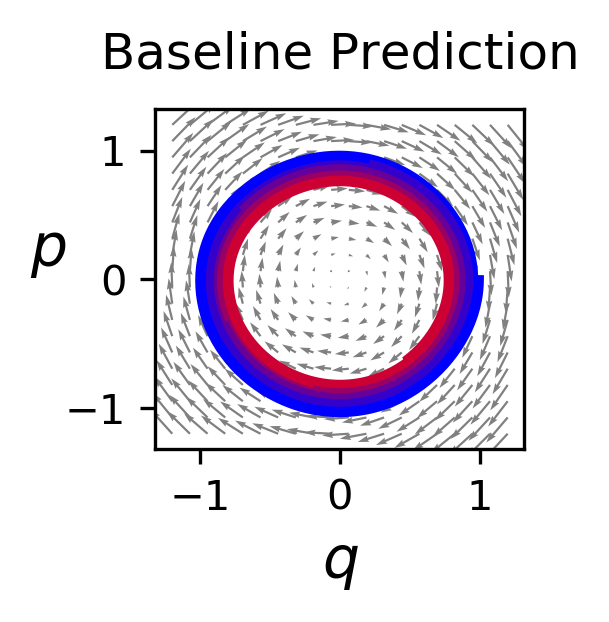

In [711]:
# plot constants
DPI = 300
LINE_SEGMENTS = 5
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2

fig = plt.figure(figsize=(7.3, 1.5), facecolor='white', dpi=DPI)

fig.add_subplot(1, 4, 3, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline Prediction", pad=10)